In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import time as tm

# Import modules containing classes and functions needed for the simulation
from src.model_ctrl import Controller, RenG, InputOL, terminalCost, gain
from src.model_sys import TwoRobots, disturbance, computePriccati
from src.model_sys_Ts1 import RobotsSystem
from src.plots import plot_trajectories, plot_traj_vs_time, plot_losses, plot_gain_eps_r
from src.loss_functions import f_loss_states, f_loss_u, f_loss_ca, f_loss_obst
from src.utils import calculate_collisions, set_params_online, set_params

# Set the random seed for reproducibility
torch.manual_seed(10)
# Set the parameters and hyperparameters for the simulation
params = set_params_online()
min_dist, t_end, n_agents, x0, xbar, linear, learning_rate, epochs, Q, alpha_u, alpha_ca, alpha_obst, n_xi, \
        l, n_traj, std_ini, gamma_bar, wmax, decayw,maxtimew, Horizon, timeInstantOpt, sim_time, gainF, n_traj_ol = params



use_OL_signal = False

In [7]:
torch.manual_seed(3)

###########################################
# Define the system model
syst = RobotsSystem(xbar,linear)
###########################################
# Define the controller model
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
OLs = InputOL(syst.n, t_end-10, active=use_OL_signal)
amplifier = gain(gamma_bar)
ctl.load_state_dict(torch.load("trained_models/OFFLINE_REN_noOL.pt", weights_only=False))
ctl.set_param()
OLs.load_state_dict(torch.load("trained_models/OFFLINE_sp_noOL.pt", weights_only=False))
amplifier.load_state_dict(torch.load("trained_models/amplifier_noOL.pt", weights_only=False))

# Define the optimizer and its parameters{'params': OLs.parameters(), 'lr': 1e-3},
optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate)
#optimizer.load_state_dict(torch.load("trained_models/OFFLINE_optimizer_noOL.pt", weights_only=False))

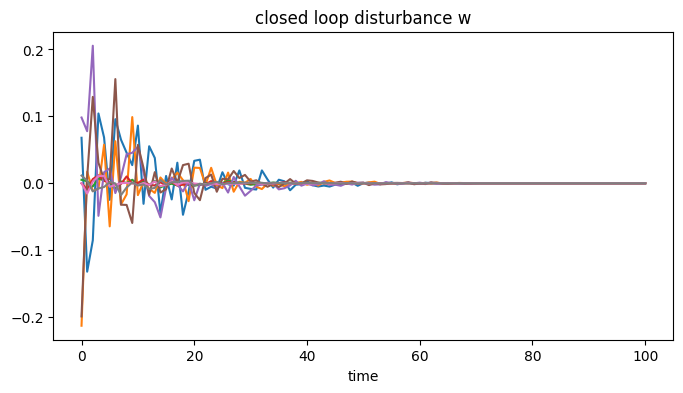

In [8]:
gamma_bar = amplifier.gamma.detach()

time = torch.linspace(0, sim_time, sim_time+1)
# GAIN https://ch.mathworks.com/help/control/ref/dynamicsysttem.norm.html

botta = 0.3
wmaxCL = wmax
w_inCL = torch.randn(sim_time + 1, syst.n)
w_in_CL = disturbance(time,w_inCL,wmax,decayw,maxtimew)
#botta = 0* torch.randn(w_in[0,:].size())
w_in_CL[1,:]= w_in_CL[1,:]+botta
w_in_CL[8,:]=w_in_CL[8,:]+botta

plt.figure(figsize=(4 * 2, 4))
plt.plot(time, w_in_CL)
plt.xlabel('time')
plt.title('closed loop disturbance w')
plt.savefig('figures/pretrain/disturbance_w.png', format='png')
#plt.show()

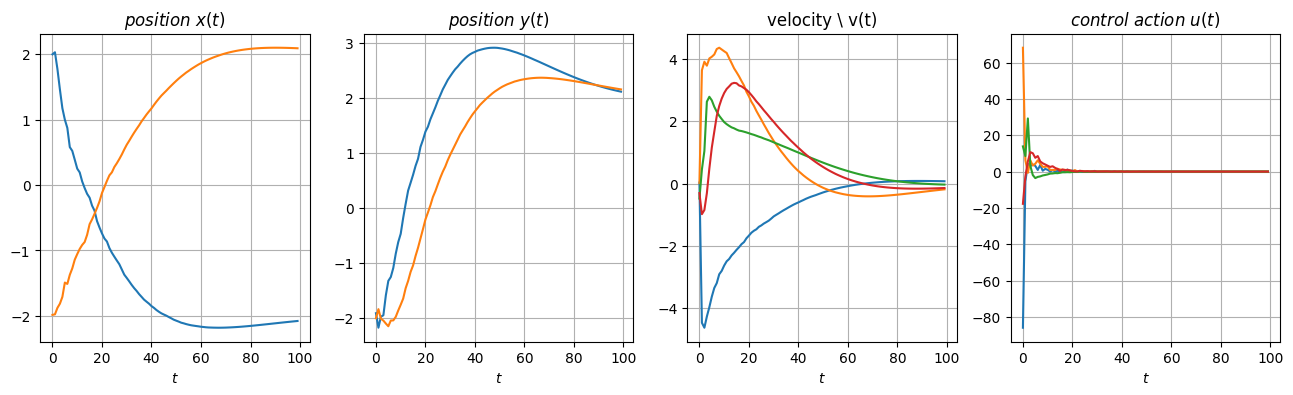

gamma bar value: 15
Number of collisions after training: 0


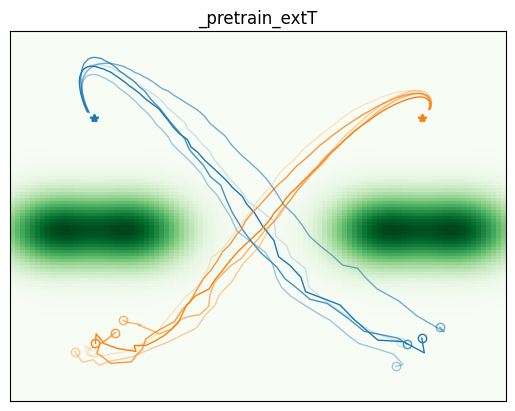

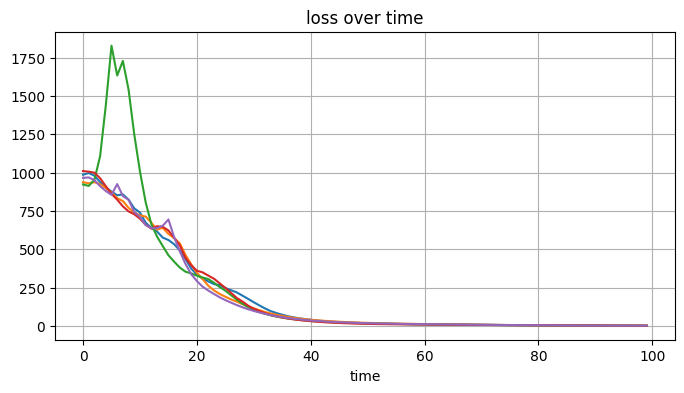

In [9]:
t_ext = t_end
# This must provide the same output as in OFFLINE
# Set the random seed for reproducibility
torch.manual_seed(99)

x_log = torch.zeros(t_ext, syst.n,n_traj)
u_log = torch.zeros(t_ext, syst.m,n_traj)
loss_log = torch.zeros((t_ext, 1, n_traj))


for traj in range(n_traj):
    w_in = torch.randn((t_ext + 1, syst.n))
    # Compute the closed-loop trajectories using the trained controller and plot them
    devx0 = std_ini * torch.randn(x0.shape)
    x = x0.detach() + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0.detach() - syst.xbar + devx0
    u, xi = ctl(0, w_REN, xi)
    usys = amplifier(u)
    for t in range(t_ext):
        x_ = x
        x_log[t, :,traj] = x.detach()
        u_log[t, :,traj] = usys.detach()
        w_syst = disturbance(t, w_in[t, :], wmax, decayw, maxtimew)
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys) + OLs(t)
        u, xi = ctl(t, w_REN, xi)
        usys = amplifier(u)
        loss_x =  f_loss_states(t, x, syst, Q)
        loss_u = alpha_u * f_loss_u(t, usys)
        loss_ca = alpha_ca * f_loss_ca(x, syst, min_dist)
        if alpha_obst != 0:
            loss_obst =  alpha_obst * f_loss_obst(x)
        loss = loss_x + loss_u + loss_ca + loss_obst
        loss_log[t,:,traj] = loss.detach()

plot_traj_vs_time(t_end, syst.n_agents, x_log[:t_end,:,0], u_log[:t_end,:,0])
print("gamma bar value: %d" % amplifier.gamma)
# Compute the number of collisions and print the result
n_coll = calculate_collisions(x_log[:,:,0], syst, min_dist)
print("Number of collisions after training: %d" % n_coll)
plot_trajectories(x_log, xbar, syst.n_agents, save=True, filename="/pretrain/CL", text="_pretrain_extT", T=t_end, obst=alpha_obst)

time = torch.linspace(0, t_ext, t_ext+1)
plt.figure(figsize=(4 * 2, 4))
for traj in range(n_traj):
    plt.plot(time[:t_ext], loss_log[:,:,traj])
plt.xlabel('time')
plt.title('loss over time')
plt.grid()
plt.show()

In [ ]:
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print pre-trained loop trajectories --------")
# Generate random initial conditions for the trajectories
x_log_pre = torch.zeros(sim_time, syst.n,n_traj_ol+1)
u_log_pre = torch.zeros(sim_time, syst.m,n_traj_ol+1)

loss_pretrained = torch.zeros(sim_time+1,n_traj_ol)
r_log_pre = torch.zeros(sim_time, 1)

for traj in range(n_traj_ol):
    devx0 = std_ini * torch.randn(x0.shape)
    w_in = torch.randn(sim_time + 1, syst.n)
    x = x0 + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0 - syst.xbar +devx0
    u, xi = ctl(0, w_REN, xi)
    usys = gamma_bar * u
    for t in range(sim_time):
        x_ = x
        if traj == 0:
            eps_pre = torch.norm(x-xbar)
            r_log_pre[t,:] = eps_pre.detach()*gainF*(gamma_bar+1)
        x_log_pre[t, :,traj] = x.detach()
        u_log_pre[t, :,traj] = usys.detach()
        w_syst = disturbance(t,w_in[t,:],wmaxCL,decayw,maxtimew)
        if t == 1 or t == 8:
            w_syst = w_syst + botta
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys) + OLs(t)
        u, xi = ctl(t, w_REN, xi)
        usys = gamma_bar * u
        loss_pretrained[t+1,traj] = loss_pretrained[t,traj] + f_loss_states(t,x,syst,Q) + alpha_u*f_loss_u(t,usys) + alpha_ca*f_loss_ca(x,syst,min_dist) + alpha_obst*f_loss_obst(x)



devx0 = std_ini * torch.randn(x0.shape)
x = x0 + devx0
xi = torch.zeros(ctl.n)
w_REN = x0 - syst.xbar + devx0
u, xi = ctl(0, w_REN, xi)
usys = gamma_bar * u
for t in range(sim_time):
    x_ = x
    x_log_pre[t, :,-1] = x.detach()
    u_log_pre[t, :,-1] = usys.detach()
    
    w_syst = disturbance(t,w_inCL[t,:],wmaxCL,decayw,maxtimew)
    if t == 1 or t == 8:
        w_syst = w_syst + botta
    x = syst(t, x, usys, w_syst)
    w_REN = x - syst.f(t, x_, usys) + OLs(t)
    u, xi = ctl(t, w_REN, xi)
    usys = gamma_bar * u
    loss_pretrained[t+1,-1] = loss_pretrained[t,-1] + f_loss_states(t,x,syst,Q) + alpha_u*f_loss_u(t,usys) + alpha_ca*f_loss_ca(x,syst,min_dist) + alpha_obst*f_loss_obst(x)
    if (t % 10 == 0) and t>0:
        plot_trajectories(x_log_pre[t-1:t,:,-1], xbar, syst.n_agents, text="Pre-trained_CL_time:%i"%t,save=False,circles=True,T=t-1, filename="trajectories" , x_=x_log_pre[0:t,:,-1], T_=t-1, obst=alpha_obst)


plot_trajectories(x_log_pre, xbar, syst.n_agents, text="Pre-trained_CL_",save=False, filename="trajectories" ,circles=True, T=sim_time-1, obst=alpha_obst)
plot_traj_vs_time(sim_time, syst.n_agents, x_log_pre[:,:,-1], u_log_pre[:,:,-1])

print("------- Check Validation trajectories --------")
plot_trajectories(x_log_pre[:,:,-1], xbar, syst.n_agents, text="Pre-trained_CLnoise",save=False, filename="trajectories" ,circles=True, T=sim_time-1, obst=alpha_obst)

plt.figure(figsize=(4 * 2, 4))
plt.plot(time, loss_pretrained[:,-1].detach())
plt.xlabel(r'sim time')
plt.title(r'loss pre training')
plt.grid()
plt.show()
print("Loss pre-trained: %i" % loss_pretrained[-1,-1] )
plt.figure(figsize=(4 * 2, 4))
plt.plot(time[:-1], r_log_pre[:,:].detach())
plt.xlabel(r'sim time')
plt.title(r'r pre training')
plt.grid()
plt.show()


------- Print pre-trained loop trajectories --------


In [ ]:
# # # # # # # # Train # # # # # # # #
# Train the controller using the NeurSLS algorithm
print("------------ Begin training ------------")
print("Problem: RH neurSLS -- t_end: %i" % t_end + " -- lr: %.2e" % learning_rate +
      " -- epochs: %i" % epochs + " -- n_traj: %i" % n_traj_ol + " -- std_ini: %.2f" % std_ini)
print(" -- alpha_u: %.1f" % alpha_u + " -- alpha_ca: %i" % alpha_ca + " -- alpha_obst: %.1e" % alpha_obst)
print("REN info -- n_xi: %i" % n_xi + " -- l: %i" % l)
print("RH info -- Horizon: %i" % Horizon)
print("--------- --------- ---------  ---------")


# Data for log
x_log = torch.zeros(sim_time+1, syst.n)
u_log = torch.zeros(sim_time, syst.m)
w_in = torch.randn(sim_time + 1, syst.n)
gainM = gamma_bar
x = x0.detach()
x_log[0, :] = x0.detach()
xi = torch.zeros(ctl.n)
w_REN = x0.detach() - syst.xbar
u, xi = ctl(0, w_REN, xi)
usys = gainM * u
# Loop for the simulation
loss_trained = np.zeros(sim_time+1)
tOL = 0
gain_log = torch.zeros(sim_time+1,1)
eps_log = torch.zeros(sim_time+1,1)

xiOR = ctl.x0

In [ ]:
episods = 1  
loss_ep = np.zeros((episods,sim_time+1))
r = 3*(r_log_pre[:,:].detach())

for episod in range(episods):
    # Data for log
    ctlRH = None
    x_log = torch.zeros(sim_time+1, syst.n)
    u_log = torch.zeros(sim_time, syst.m)
    w_in = torch.randn(sim_time + 1, syst.n)
    gainM = gamma_bar
    x = x0
    if x.dtype is not torch.float:
        x = x.to(torch.float)
    x_log[0, :] = x0.detach()
    xi = torch.zeros(ctl.n)
    w_REN = x0.detach() - syst.xbar
    if ctlRH is None:
        u, xi = ctl(0, w_REN, xi)
        xiOR = ctl.x0
    else:
        u, xi = ctlRH(0, w_REN, xi)
        xiOR = ctlRH.x0
    usys = gainM * u
    # Loop for the simulation
    loss_trained = np.zeros(sim_time+1)
    tOL = 0
    gain_log = torch.zeros(sim_time+1,1)
    eps_log = torch.zeros(sim_time+1,1)
    
    for tsim in range(sim_time):
        # Compute the next state and control input using the systtem and controller models
        x_ = x
        u_log[tsim, :] = usys.detach()
        gain_log[tsim,:] = (r[tsim] / (gainF * torch.norm(x.detach()-xbar)))-1
        eps_log[tsim,:] = torch.norm(x.detach()-xbar)
        w_sys = disturbance(tsim,w_in_CL[tsim,:],wmaxCL,decayw,maxtimew)
        if tsim == 1 or tsim == 8:
            w_sys = w_sys + botta
        x = syst(tsim, x, usys, w_sys)
        x_log[tsim+1, :] = x.detach()
        w_est = x - syst.f(tsim, x_, usys)
    
        if (torch.max(w_est)>botta) or( (tsim % timeInstantOpt == 0) ):# and (tsim>0)):
            eps = torch.norm(x-syst.xbar)
            gainMt = (r[tsim] / (gainF * eps.detach()))-1
            if (gainMt.item() >0):
                gainM = gainMt
                print("Simulation time: %i  ---  |x-xbar|: %1f--- gainM: %1f" % (tsim, torch.norm(x-syst.xbar), gainM))
                # Loop over the specified number of epochs
                x0t = x.detach()
                loss_list = np.zeros(epochs)
                #######OLs = InputOL(syst.n, Horizon, active=use_OL_signal)
                # Define the optimizer and its parameters
                #######optimizer = torch.optim.Adam(list(ctl.parameters()) + list(OLs.parameters()), lr=learning_rate)
                #optimizer.load_state_dict(torch.load("trained_models/OFFLINE_optimizer.pt", weights_only=False))
                if ctlRH is None:
                    ctlRH = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
                    ctlRH.load_state_dict(torch.load("trained_models/OFFLINE_REN_noOL.pt", weights_only=False))
                    ctlRH.set_param()
                state_dict = ctlRH.state_dict()
                state_dict['ctlRH.x0'] = xi.detach()
                ctlRH.set_param()
                #state_dict['ctlRH.x0'] = xiOR
                optimizer = torch.optim.Adam([{'params': ctlRH.parameters()}], lr=learning_rate)
                for epoch in range(epochs):
                    if epoch > 0:
                        del xt,w_int,xit,w_RENt,ut,usyst,loss
                    # Reset the gradients of the optimizer
                    optimizer.zero_grad()
                    # Initialize the loss and its components for this epoch
                    loss_x, loss_u, loss_ca, loss_obst = 0, 0, 0, 0
                    # Loop over the specified number of trajectories
                    xt_log = torch.zeros(Horizon, syst.n, n_traj_ol)
                    ut_log = torch.zeros(Horizon, syst.m, n_traj_ol)
                    for kk in range(n_traj_ol):
                        w_int = torch.randn((sim_time + Horizon+1, syst.n))
                        devx0 = std_ini * torch.zeros(x0.shape)
                        xt = x0t + devx0
                        xit = xi.detach()
                        #xit = torch.zeros(ctl.n)
                        w_RENt = x0t.detach() - syst.xbar + devx0
                        ut, xit = ctlRH(0, w_RENt, xit)
                        usyst = gainM * ut
                        for t in range(Horizon):
                            xt_ = xt
                            # Compute the next state and control input using the system and controller models
                            xt_log[t, :,kk] = xt.detach()
                            ut_log[t, :,kk] = usyst.detach()
                            w_syst = disturbance(tsim+t, w_int[tsim+t, :], wmax, decayw, maxtimew)
                            xt = syst(tsim+t, xt, usyst, w_syst)
    
                            w_RENt = xt - syst.f(tsim+t, xt_, usyst) + OLs(tsim+t)
                            ut, xit = ctlRH(tsim+t, w_RENt, xit)
                            usyst = gainM * ut
    
                            # Compute the loss and its components for this time step
                            loss_x = loss_x + f_loss_states(t, xt, syst, Q)
                            loss_u = loss_u + alpha_u * f_loss_u(t, usyst)
                            loss_ca = loss_ca + alpha_ca * f_loss_ca(xt, syst, min_dist)
                            if alpha_obst != 0:
                                loss_obst = loss_obst + alpha_obst * f_loss_obst(xt)
                            if t == Horizon-1:
                                n_traj_tc = 1
                                t_end = sim_time - tsim
                                P = computePriccati(syst, 10*Q,alpha_u*torch.eye(syst.m))
                                loss_x = loss_x + f_loss_states(t, xt, syst, P)
                                #loss_x = loss_x + 100*f_loss_states(t, xt, syst, Q)
                                #loss_x = loss_x + terminalCost(tsim+t,xt,syst,ctl_prec,n_traj_tc,t_end,gamma_bar,wmax,decayw,maxtimew,OLs_prec,alpha_u,alpha_ca,min_dist,Q,alpha_obst,xit)
    
                    # Compute the total loss for this epoch and log its components
                    loss = loss_x + loss_u + loss_ca + loss_obst
                    print("Epoch: %i --- Loss: %.4f ---||--- Loss x: %.2f --- " % (epoch, loss, loss_x) +
                          "Loss u: %.2f --- Loss ca: %.2f --- Loss obst: %.2f" % (loss_u, loss_ca, loss_obst) +
                          " Simulation time: %i "% (tsim))
                    loss_list[epoch] = loss.detach()
    
                    # Backpropagate the loss through the controller model and update its parameters
                    start_time = tm.time()
                    loss.backward(retain_graph=True)
                    end_time = tm.time()
                    elapsed_time = end_time - start_time
                    print(f"Backward pass took {elapsed_time:.6f} seconds")
                    print(f"Backward pass for all epochs took {elapsed_time*epochs:.6f} seconds")
                    
                    
                    optimizer.step()
                    ctlRH.set_param()
    
                #ctl_prec = ctl
                #OLs_prec = OLs
                plot_trajectories(xt_log, xbar, syst.n_agents, text="",circles=True,  save=True, filename="CL_RH_Hor_%.1f_time_%i" %(Horizon,tsim) , T=Horizon, obst=alpha_obst, x_=x_log, T_=tsim+1)

                if (tsim%10==0 and episod%3==0 and tsim<75):
                    plot_trajectories(xt_log, xbar, syst.n_agents, text="time instant: %.1f --- episod %.1f" % (tsim ,episod),circles=True,  save=False, filename="CL_RH Horizon: %.1f " %Horizon , T=Horizon, obst=alpha_obst, x_=x_log, T_=tsim+1)
                #plot_trajectories(xt_log, xbar, syst.n_agents, text="time instant: %.1f" % tsim , save=True, filename="CL_RH Horizon: %.1f " %Horizon , T=Horizon, obst=alpha_obst, x_=x_log, T_=tsim+1)
                
                
                    time_epoch = torch.linspace(0, epochs-1, epochs)
                    plt.figure(figsize=(4 * 2, 4))
                    plt.plot(time_epoch, loss_list[:])
                    plt.xlabel(r'epochs')
                    plt.title(r'loss RH')
                    plt.grid()
                    plt.show()
                    
                    plot_gain_eps_r(r,gainF,tsim,gain_log,eps_log)
                
                w_REN = x.detach() - syst.xbar
                xi = torch.zeros(ctl.n)
                u, xi = ctlRH(0, w_REN, xi)
                usys = gainM * u
                tOL = 0
            else:
                warnings.warn("gain NEGATIVO.", UserWarning)
                plot_gain_eps_r(r,gainF,tsim,gain_log,eps_log)
                w_REN = x - syst.f(tsim, x_, usys) + OLs(tOL)
                u, xi = ctlRH(0, w_REN, xi)
                usys = gainM * u
                tOL = tOL +1
                
                
    
        else:
            w_REN = x - syst.f(tsim, x_, usys) + OLs(tOL)
            u, xi = ctlRH(tsim, w_REN, xi)
            usys = gainM * u
            tOL = tOL +1
    
        loss_trained[tsim+1] = loss_trained[tsim]+f_loss_states(tsim, x, syst, Q)+alpha_u * f_loss_u(tsim, usys)+alpha_ca * f_loss_ca(x, syst, min_dist)+ alpha_obst * f_loss_obst(x)
    loss_ep[episod,:]=loss_trained[:]

In [ ]:
plot_traj_vs_time(sim_time, syst.n_agents, x_log[:-1,:], u_log)
# Plot and log the closed-loop trajectories with pre-trained network
print("------- Print trained closed-loop trajectories --------")
plot_trajectories(x_log[:,:], xbar, syst.n_agents, text="CL_RH",save=False, filename="trajectories_RH" , T=sim_time, obst=alpha_obst)
plot_trajectories(x_log_pre[:,:,-1], xbar, syst.n_agents, text="CL_offline",save=False, filename="trajectories_RH" , T=sim_time, obst=alpha_obst)

time = torch.linspace(0, sim_time, sim_time+1)
plt.figure(figsize=(4 * 2, 4))
plt.plot(time, loss_pretrained[:,-1].detach(), label="loss offline ")

colors = plt.colormaps['Oranges']
for episod in range(episods):
    plt.plot(time, loss_ep[episod,:], color=colors(1-episod/episods),label="RH episod %i" % episod)
#plt.plot(time, loss_trained[:])
plt.xlabel(r'sim time')
plt.title(r'$loss$')
plt.legend()
plt.savefig('figures/Loss_comparison.png', format='png')